In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import AalenAdditiveFitter
import patsy



%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [2]:
# Session level data
ses = pd.read_csv("data/yup-sessions-2017-06-29.csv")
ses.columns = [col.strip() for col in ses.columns]
#Message Level Dat
msg = pd.read_csv("data/yup-messages-2017-06-29.csv")

#column cleaning
msg['created_at_clean'] = pd.to_datetime(msg.created_at.astype(str).str[:-4], format='%Y-%m-%d %H:%M:%S', errors='ignore')
msg['text_readable'] = msg.sent_from +': '+ msg.text
ses['timestamp_clean'] = pd.to_datetime(ses.timestamp.astype(str).str[:-4], format='%Y-%m-%d %H:%M:%S', errors='ignore')
ses.loc[(ses.timestamp_clean >='2016-06-13 00:00:00') & (ses.timestamp_clean <= '2016-08-18 00:00:00'),'no_paywall'] = 1
ses.loc[(ses.timestamp_clean >='2016-03-16 00:00:00') & (ses.timestamp_clean <= '2016-04-12 00:00:00'),'no_paywall'] = 1
ses['no_paywall'] = ses.no_paywall.fillna(value=0)

#merge two tables
df_all = msg.merge(ses, on = 'session_id')
#subset out rubric questions and take out all uncategorized sessions
subset_cols =ses.columns[:42].append(ses.columns[-1:])
ses_1_42 = ses[subset_cols]
ses_1_42 = ses_1_42[-ses_1_42.consolidated_session_category.isin(['no-msg-sent', None, 'connection-issue'])]
ses_1_42['year-month'] = ses_1_42.timestamp_clean.astype(str).str[:7]

# New Transformations
ses_1_42.loc[ses_1_42.consolidated_session_category == "gap-bridged", 'gb_bool'] = 1
ses_1_42.loc[ses_1_42.consolidated_session_category != "gap-bridged", 'gb_bool'] = 0


/Users/ricky/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ricky/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Student-level data cleaning

# V1 : All students
#Groupbys to join
ses_cnt_by_student = ses_1_42.groupby('student_id').count()['session_id']
gb_cnt_by_student = ses_1_42[ses_1_42.consolidated_session_category == 'gap-bridged']\
.groupby('student_id').count()['session_id']
first_gb_by_student = ses_1_42[ses_1_42.consolidated_session_category == 'gap-bridged'].groupby('student_id')['timestamp_clean'].min()
first_session_by_student = ses_1_42.groupby('student_id')['timestamp_clean'].min()
most_used_platform_by_student = ses_1_42.groupby('student_id')['student_platform'].agg(lambda x:x.value_counts().index[0])

#Student level data cleaning and exploration
students = pd.DataFrame(ses_cnt_by_student).reset_index()
gbc = pd.DataFrame(gb_cnt_by_student).reset_index()
first_gb = pd.DataFrame(first_gb_by_student).reset_index()
first_session = pd.DataFrame(first_session_by_student).reset_index()
most_used_platform = pd.DataFrame(most_used_platform_by_student).reset_index()
bridged_ts = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == 'gap-bridged'].groupby('student_id')['timestamp_clean'].apply(np.array)).reset_index()
unbridged_ts = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category != 'gap-bridged'].groupby('student_id')['timestamp_clean'].apply(np.array)).reset_index()
last_ub = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category != 'gap-bridged'].groupby('student_id')['timestamp_clean'].max()).reset_index()
most_subject = pd.DataFrame(ses_1_42.groupby('student_id')['subject'].agg(lambda x:x.value_counts().index[0])).reset_index()

#merge into students df
students = students.merge(gbc, how = 'left' , on = 'student_id')
students = students.merge(first_gb,how = 'left' , on = 'student_id')
students = students.merge(last_ub ,how = 'left' , on = 'student_id')
students = students.merge(first_session ,how = 'left' , on = 'student_id')
students = students.merge(most_used_platform ,how = 'left' , on = 'student_id')
students = students.merge(most_subject ,how = 'left' , on = 'student_id')
students = students.merge(bridged_ts ,how = 'left' , on = 'student_id')
students = students.merge(unbridged_ts ,how = 'left' , on = 'student_id')

#rename columns
students.columns = ['student_id', 'session_count', 'gb_count', 'first_gb', 'last_ub', 'first_session', 'most_used_platform'\
                   ,'most_subject','bridged_ts_list', 'unbridged_ts_list']

#clean and create new columns
students['first_gb'] = students['first_gb'].fillna(value = pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'))
students = students.fillna(value=0) #Note this created cells where NA -> 1970 dt object in first_gb column
students['gb_rate'] = 1.0*students.gb_count / students.session_count
students['time_to_gb'] = students.first_gb - students.first_session 
students['days_to_gb'] = students.time_to_gb.astype('timedelta64[D]')
students['days_to_gb'] = students['days_to_gb']+1 #to combat zero day in survival analysis
students.loc[students['first_gb'] != pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 1
students.loc[students['first_gb'] == pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 0
students.loc[students['last_ub'] > students['first_gb'], 'unbridged_after_gb'] = 1
students.loc[students['last_ub'] < students['first_gb'], 'unbridged_after_gb'] = 0

# merge all student level information
ses_1_42 = ses_1_42.merge(students, how = 'left', on = 'student_id')



#post merge session adding
ses_1_42['days_since_ses_1'] = (ses_1_42.timestamp_clean - ses_1_42.first_session ).astype('timedelta64[D]')
'''
#On hold until survival starts back up
#V2 : Limit to at least 5 gap bridged
students_gb5 = students[(students.gb_count > 4)]
students_gb5['bridged_ts5'] = students_gb5['bridged_ts_list'].str[4]
students_gb5['days_to_gb_5'] = (students_gb5.bridged_ts5 - students_gb5.first_session).astype('timedelta64[D]') + 1

#V3 : At least 5 sessions, death defined as getting to 5 gap_bridged
students_gb5 = students[(students.session_count > 4)]
students_gb5['bridged_ts5'] = students_gb5['bridged_ts_list'].str[4]
students_gb5['bridged_ts5'] = students_gb5['bridged_ts5'].fillna(value = pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'))
students_gb5.loc[students_gb5['bridged_ts5'] != pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 1
students_gb5.loc[students_gb5['bridged_ts5'] == pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 0
students_gb5['days_to_gb_5'] = (students_gb5.bridged_ts5 - students_gb5.first_session).astype('timedelta64[D]') + 1
#Subseting out system msgs
msg = msg[(msg.sent_from == 'student') | (msg.sent_from == 'tutor')]
msg = msg.drop_duplicates(['created_at', 'text'])
'''

"\n#On hold until survival starts back up\n#V2 : Limit to at least 5 gap bridged\nstudents_gb5 = students[(students.gb_count > 4)]\nstudents_gb5['bridged_ts5'] = students_gb5['bridged_ts_list'].str[4]\nstudents_gb5['days_to_gb_5'] = (students_gb5.bridged_ts5 - students_gb5.first_session).astype('timedelta64[D]') + 1\n\n#V3 : At least 5 sessions, death defined as getting to 5 gap_bridged\nstudents_gb5 = students[(students.session_count > 4)]\nstudents_gb5['bridged_ts5'] = students_gb5['bridged_ts_list'].str[4]\nstudents_gb5['bridged_ts5'] = students_gb5['bridged_ts5'].fillna(value = pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'))\nstudents_gb5.loc[students_gb5['bridged_ts5'] != pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 1\nstudents_gb5.loc[students_gb5['bridged_ts5'] == pd.to_datetime('2017-06-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 'observed'] = 0\nstudents_gb5['days_to_gb_5'] = (students_gb5.bridged_ts5 - students_gb5.first_s

In [4]:
#Subseting out system msgs
msg = msg[(msg.sent_from == 'student') | (msg.sent_from == 'tutor')]
msg = msg.drop_duplicates(['created_at', 'text'])

# Count total, tutor and student msg counts
msg_count_by_ses = pd.DataFrame(msg.groupby('session_id').count()['created_at']).reset_index()
msg_stu_count_by_ses = pd.DataFrame(msg[(msg.sent_from == 'student')].groupby('session_id').count()['created_at']).reset_index()
msg_tut_count_by_ses = pd.DataFrame(msg[(msg.sent_from == 'tutor')].groupby('session_id').count()['created_at']).reset_index()
msg_count_by_ses.columns = ['session_id', 'total_count_msg']
msg_stu_count_by_ses.columns = ['session_id', 'stu_count_msg']
msg_tut_count_by_ses.columns = ['session_id', 'tut_count_msg']

#gone mergin'
ses_1_42 = ses_1_42.merge(msg_count_by_ses, how = 'left', on = 'session_id')
ses_1_42 = ses_1_42.merge(msg_stu_count_by_ses, how = 'left', on = 'session_id')
ses_1_42 = ses_1_42.merge(msg_tut_count_by_ses, how = 'left', on = 'session_id')

#Take text and count words and put into df to join to session master data set
msg['text'] = msg['text'].astype(str)
msg['text_lower'] = [t.lower() for t in msg.text]
full_transcript_by_session = pd.DataFrame(msg[msg.content_type == 'text'].groupby('session_id')['text'].apply(list)).reset_index()
joined_text = [" ".join(transcript) for transcript in  full_transcript_by_session.text]
split_of_transcript = [t.split() for t in joined_text]
length_list = [len(t) for t in split_of_transcript]
char_list = [len(t) for t in joined_text]
question_count_list = [t.count('?') for t in joined_text]
msg_question_count =  [t.count('?') for t in msg.text]

full_transcript_by_session['text'] = joined_text
full_transcript_by_session['word_count'] = length_list
full_transcript_by_session['char_count'] = char_list
full_transcript_by_session['question_count'] = question_count_list
ses_1_42 = ses_1_42.merge(full_transcript_by_session, how = 'left', on = 'session_id')

ques_start = ['how', 'what', 'when' , 'where' , 'why', 'can']
for word in ques_start:
    _ls = [t.strip()[:len(word)].count(word) for t in msg.text_lower]
    msg[word] = _ls

#merging question start counts to sessions
msg['question_student_count'] = np.array([t.count("?") for t in msg.text_lower])
msg['first_word'] = [ None if t.split()==[] else t.split()[0] for t in msg.text_lower]
ses_1_42 = ses_1_42.merge(pd.DataFrame(msg.groupby('session_id')[ques_start].sum()).reset_index(), how = 'left', on = 'session_id')
#This turns question start + "_x" into a count of all question starts and question start + "_y" into just student questions 
ses_1_42 = ses_1_42.merge(pd.DataFrame(msg[(msg.sent_from == 'student')].groupby('session_id')[ques_start].sum()).reset_index(), how = 'left', on = 'session_id')
ses_1_42 = ses_1_42.merge(pd.DataFrame(msg[(msg.sent_from == 'student')].groupby('session_id')['question_student_count'].sum()).reset_index(), how = 'left', on = 'session_id')




#Note missing values found here -> #ses_1_42[(pd.isnull(ses_1_42.word_count))
#no message data for 5K sessions
# here are gb with no msg data: ses_1_42[(pd.isnull(ses_1_42.word_count)) &\(ses_1_42.consolidated_session_category == 'gap-bridged')]['session_id']
#All the sessions without missing message data
# some may be no stud msg, connection isuue, etc
ses_full = ses_1_42[(pd.notnull(ses_1_42.word_count))]
#This creates incompleteness here as well 
#to correct I'll filter out all student ids that appear in sessions without message data
students_full = students[-students.student_id.isin(ses_1_42[pd.isnull(ses_1_42.word_count)]['student_id'])]

#merging student session group by to apprpriate stduent population
students_full = students_full.merge(pd.DataFrame(ses_full.groupby('student_id')['question_student_count'].sum()).reset_index(), how = 'left', on = 'student_id')

students_full['question_student_count_ratio'] = 1.0*students_full['question_student_count'] / students_full['session_count']
ses_full['ses_num_order'] = ses_full.groupby('student_id').cumcount()
ses_full['ses_num_order'] = ses_full['ses_num_order'] + 1



/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Exploratory Data Analysis: Session, Message and Student Data

## Session

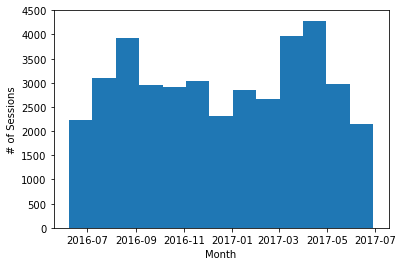

In [14]:
plt.hist(ses_1_42.timestamp_clean.values, bins =13)
plt.xlabel('Month')
plt.ylabel('# of Sessions')

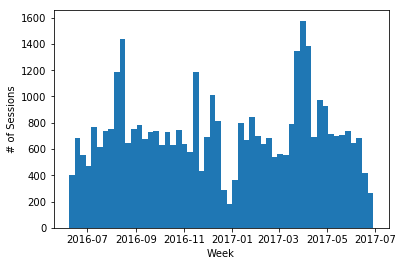

In [15]:
plt.hist(ses_1_42.timestamp_clean.values, bins = 54)
plt.xlabel('Week')
plt.ylabel('# of Sessions')

* Two Largest peaks in number of sessions are the begining and end of the 2016-2017 school year.
* The lowest point is in December.
* Looking at number of sessions by week below, there are some isolated drops around thanksgiving and Christmas.

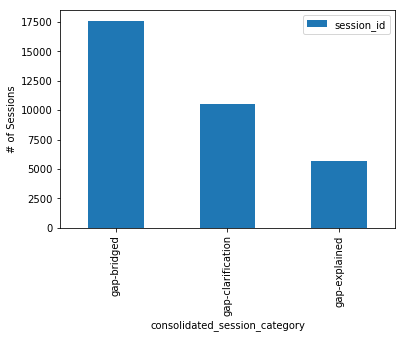

In [65]:
## Learning outcomes
learning_outcome_counts = pd.DataFrame(ses_1_42.groupby('consolidated_session_category').count()['session_id'])
learning_outcome_counts.plot(kind='bar')
plt.ylabel('# of Sessions')






* We see that the majority class, ~45% of graded sessions, is "gap-bridged"(the successful learning outcome). "gap-explained"(moderate success) and "gap-clarification"(minimal success)
* This means our overall learning success rate of 52%

In [5]:
monthly_all = pd.DataFrame(ses_1_42.groupby('year-month').count()['session_id']).reset_index()
monthly_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('year-month').count()['session_id']).reset_index()
monthly_all = monthly_all.merge(monthly_gb, on = 'year-month')
monthly_all['gb_rate'] = 1.0* monthly_all.session_id_y /monthly_all.session_id_x 

In [6]:
monthly_all = monthly_all.set_index('year-month')

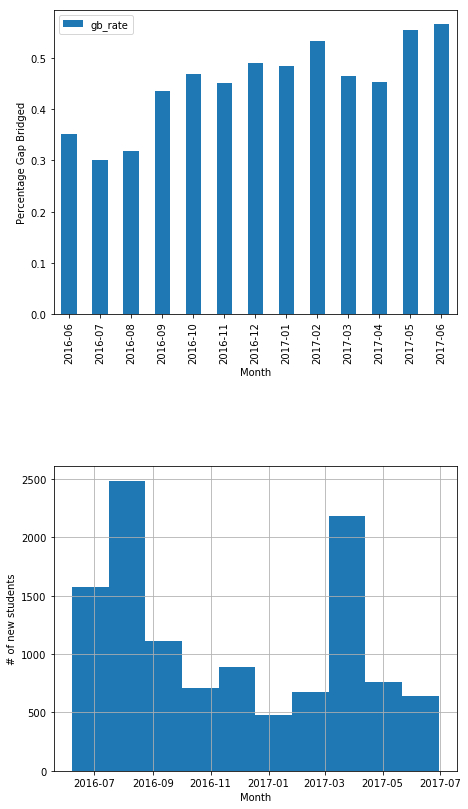

In [14]:
fig = plt.figure(figsize= (8,14))

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


monthly_all.drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar', ax = ax1)
ax1.set_xlabel('Month')
ax1.set_ylabel('Percentage Gap Bridged')


students.first_session.hist( ax = ax2)
ax2.set_xlabel('Month')
ax2.set_ylabel('# of new students')

plt.subplots_adjust(hspace=0.5, left=0.2)

* We see a matching effect with new students and drops in gb rate, particularily in August.
    * This suggests some type of interaction between time since first session and gap bridged student performance

In [120]:
subject_all = pd.DataFrame(ses_1_42.groupby('subject').count()['session_id']).reset_index()
subject_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('subject').count()['session_id']).reset_index()
subject_all = subject_all.merge(subject_gb, on = 'subject')
subject_all['gb_rate'] = 1.0* subject_all.session_id_y /subject_all.session_id_x 

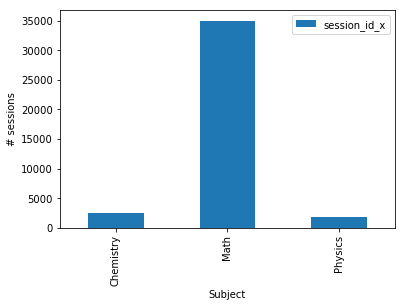

In [134]:
subject_all.set_index('subject').drop(['gb_rate', 'session_id_y'], axis = 1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('# sessions')

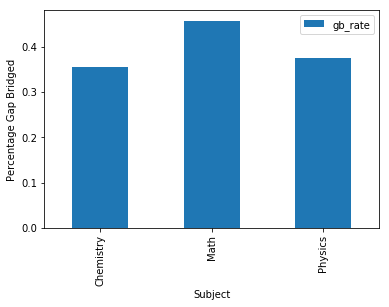

In [126]:
subject_all.set_index('subject').drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('Percentage Gap Bridged')

* ~88% Math sessions
* Math has a gap bridged rate 10% higher than Chemistry and 8% higher than Physics.

In [148]:
subject_all

,subject,session_id_x,session_id_y,gb_rate
0,Chemistry,2493,888,0.356197
1,Math,34989,16004,0.457401
2,Physics,1880,705,0.375000


In [131]:
subtopic_all = pd.DataFrame(ses_1_42.groupby('subtopic').count()['session_id']).reset_index()
subtopic_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('subtopic').count()['session_id']).reset_index()
subtopic_all = subtopic_all.merge(subtopic_gb, on = 'subtopic')
subtopic_all['gb_rate'] = 1.0* subtopic_all.session_id_y /subtopic_all.session_id_x 

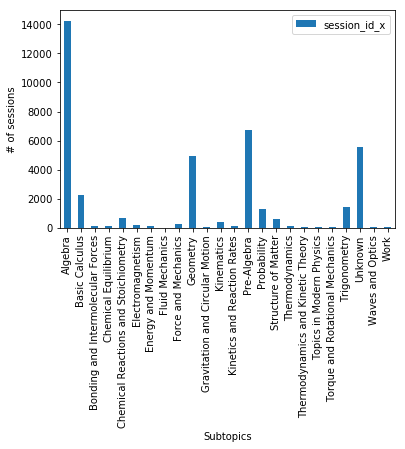

In [137]:
subtopic_all.set_index('subtopic').drop(['session_id_y', 'gb_rate'], axis = 1).plot(kind='bar')
plt.xlabel('Subtopics')
plt.ylabel('# of sessions')

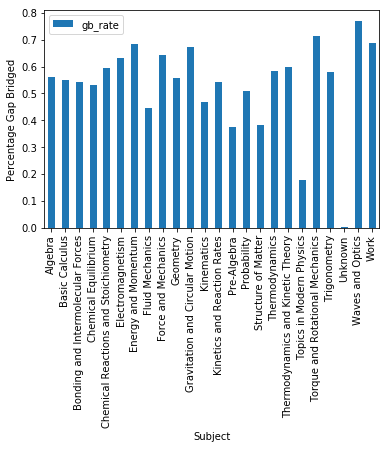

In [133]:
subtopic_all.set_index('subtopic').drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('Percentage Gap Bridged')

* Much like subject, subtopic is heavily weighted towards Math related areas of the study
* The clear top 3 are Algebra, Pre-Algebra and Geometry.
* Interestingly Pre-Algebra has a gap bridged rate 19% less than Alegebra, 56% versus 37% respectively.
    * Possible indication of a steep learning curve. 

In [143]:
student_platform_all = pd.DataFrame(ses_1_42.groupby('student_platform').count()['session_id']).reset_index()
student_platform_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('student_platform').count()['session_id']).reset_index()
student_platform_all = student_platform_all.merge(student_platform_gb, on = 'student_platform')
student_platform_all['gb_rate'] = 1.0* student_platform_all.session_id_y /student_platform_all.session_id_x 

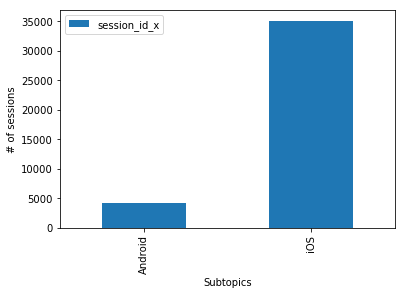

In [144]:
student_platform_all.set_index('student_platform').drop(['session_id_y', 'gb_rate'], axis = 1).plot(kind='bar')
plt.xlabel('platform')
plt.ylabel('# of sessions')

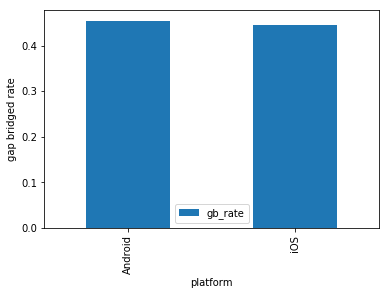

In [146]:
student_platform_all.set_index('student_platform').drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar')
plt.xlabel('platform')
plt.ylabel('gap bridged rate')

* ~88% iOS
* Only 0.8% difference in gap bridged rate

In [33]:
#Some mean comparison on gap bridged

new_cols = list(ses_full.columns[-7:])
for c in new_cols:
    print ses_full.groupby('gb_bool')[c].mean()

gb_bool
0.0    0.106619
1.0    0.351553
Name: how_y, dtype: float64
gb_bool
0.0    0.126188
1.0    0.397992
Name: what_y, dtype: float64
gb_bool
0.0    0.009222
1.0    0.043113
Name: when_y, dtype: float64
gb_bool
0.0    0.012428
1.0    0.050329
Name: where_y, dtype: float64
gb_bool
0.0    0.018276
1.0    0.089928
Name: why_y, dtype: float64
gb_bool
0.0    0.119215
1.0    0.329840
Name: can_y, dtype: float64
gb_bool
0.0    3.208345 
1.0    11.334045
Name: question_student_count, dtype: float64


In [59]:
ses_1_42[(pd.notnull(ses_1_42.length_of_session)) & (pd.notnull(ses_1_42.avg_tutor_response_time)) & (pd.notnull(ses_1_42.max_tutor_response_time))].describe().T

,count,mean,std,min,25%,50%,75%,max
session_id,33228,322191,12500.4,299889,311566,322512,332902,343367
tutor_id,33228,159749,167383,2,34864,54661,300294,531110
student_id,33228,421662,127141,52,385563,424178,522692,609630
feedback_score,33098,0.62312,0.458153,0,0,0.9,1,1
wait_time,33228,23.2164,88.37,1.36771,5.77364,8.16371,13.7699,3450.46
student_rating,30226,4.19751,1.53107,0,5,5,5,5
length_of_session,33228,-1.60058e+07,1.61202e+08,-1.49565e+09,429.996,1004.28,1970.74,1.48606e+09
avg_tutor_response_time,33228,32.5673,1036.87,0.00503778,14.2241,19.2501,26.2056,129541
max_tutor_response_time,33228,77.4936,1038.52,0.00503778,34.4697,53.4737,81.7549,129541
tutor_math_exam_score,27810,89.4899,10.6019,12,84,92,100,100


## Students

In [17]:
# New Transformations
ses_1_42 = ses_1_42.merge(students, on = 'student_id')
ses_1_42.loc[ses_1_42.consolidated_session_category == "gap-bridged", 'gb_bool'] = 1
ses_1_42.loc[ses_1_42.consolidated_session_category != "gap-bridged", 'gb_bool'] = 0
ses_1_42['days_since_ses_1'] = (ses_1_42.timestamp_clean - ses_1_42.first_session ).astype('timedelta64[D]')

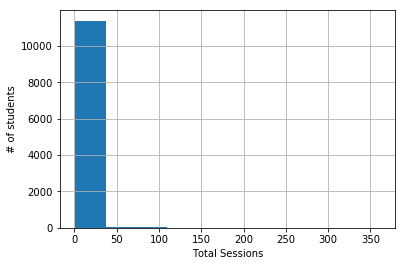

In [38]:

students.session_count.hist()
plt.xlabel("Total Sessions")
plt.ylabel("# of students")


* Almost all students have participated in less than 40 sessions.

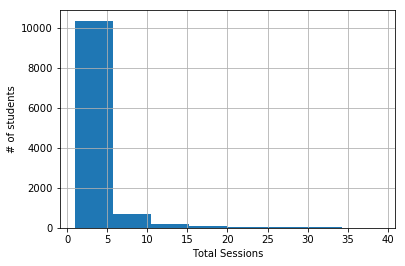

In [40]:

students[students.session_count< 40].session_count.hist(bins = 8)
plt.xlabel("Total Sessions")
plt.ylabel("# of students")

* Of these students with 40 or less sessions there remains a large cluster with 5 or less sessions.

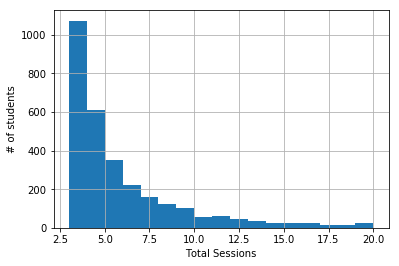

In [43]:

students[(students.session_count>=3)&(students.session_count<=20)].session_count.hist(bins = 17)
plt.xlabel("Total Sessions")
plt.ylabel("# of students")

* Here's a view looking at students with at least 3 sessions, but less than 20. 
* I would classify these students as the useable population for the analysis. There are 2970 students in this subset.

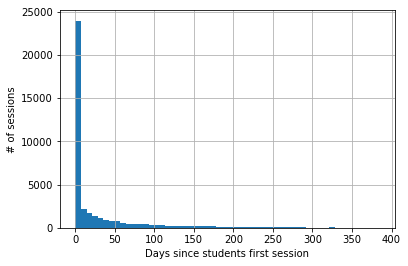

In [48]:
ses_1_42.days_since_ses_1.hist(bins = 54)
plt.xlabel("Days since students first session")
plt.ylabel("# of sessions")



* This shows that the vast majority of users do not use over  a long period of time most students will complete all their sessions within the space of a few days.

* Here's a comparison of mean for a selection of numerical variables grouped by 'gb_bool' (a boolean of whether gap-bridged was achieved or not.
    * wait_time(seconds) - gap bridged sessions have approx half the wait time as non-gap bridged.
    * len

In [58]:
ses_1_42[(pd.notnull(ses_1_42.length_of_session)) & (pd.notnull(ses_1_42.avg_tutor_response_time)) & (pd.notnull(ses_1_42.max_tutor_response_time))].groupby('gb_bool').mean()[['wait_time', 'length_of_session', 'student_complained','avg_tutor_response_time','max_tutor_response_time']].T





gb_bool,0.0,1.0
wait_time,2.206801e+01,2.424483e+01
length_of_session,-1.670071e+07,-1.538359e+07
student_complained,4.118359e-01,3.342841e-01
avg_tutor_response_time,3.773124e+01,2.794309e+01
max_tutor_response_time,7.148899e+01,8.287077e+01


In [59]:
#LOOK AT MAX MIN AND CREATE BETTTER VARIABLES WITH MESSAGE DATA
ses_1_42[(pd.notnull(ses_1_42.length_of_session)) & (pd.notnull(ses_1_42.avg_tutor_response_time)) & (pd.notnull(ses_1_42.max_tutor_response_time))].describe().T

,count,mean,std,min,25%,50%,75%,max
session_id,33228,322191,12500.4,299889,311566,322512,332902,343367
tutor_id,33228,159749,167383,2,34864,54661,300294,531110
student_id,33228,421662,127141,52,385563,424178,522692,609630
feedback_score,33098,0.62312,0.458153,0,0,0.9,1,1
wait_time,33228,23.2164,88.37,1.36771,5.77364,8.16371,13.7699,3450.46
student_rating,30226,4.19751,1.53107,0,5,5,5,5
length_of_session,33228,-1.60058e+07,1.61202e+08,-1.49565e+09,429.996,1004.28,1970.74,1.48606e+09
avg_tutor_response_time,33228,32.5673,1036.87,0.00503778,14.2241,19.2501,26.2056,129541
max_tutor_response_time,33228,77.4936,1038.52,0.00503778,34.4697,53.4737,81.7549,129541
tutor_math_exam_score,27810,89.4899,10.6019,12,84,92,100,100


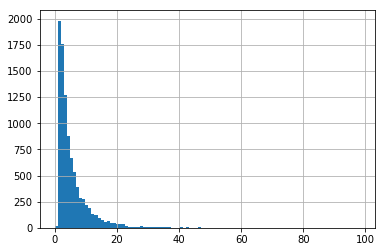

In [34]:
students_full.question_student_count_ratio.hist(bins=100)

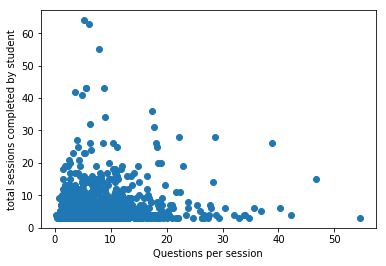

In [37]:
plt.scatter(students_full[students_full.session_count >2].question_student_count_ratio, students_full[students_full.session_count >2].session_count)
plt.xlabel('Questions per session')
plt.ylabel('total sessions completed by student')



mean questions per session over .5 gb rate
7.84197878656
mean questions per session below .5 gb rate
3.29603433612


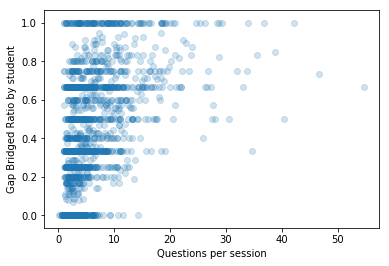

In [50]:
plt.scatter(students_full[students_full.session_count >2].question_student_count_ratio,\
            students_full[students_full.session_count >2].gb_rate\
           , alpha = 0.2)
plt.xlabel('Questions per session')
plt.ylabel('Gap Bridged Ratio by student')

print 'mean questions per session over .5 gb rate'
print students_full[students_full.gb_rate >= 0.5].question_student_count_ratio.mean()
print 'mean questions per session below .5 gb rate'
print students_full[students_full.gb_rate < 0.5].question_student_count_ratio.mean()

/Users/ricky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


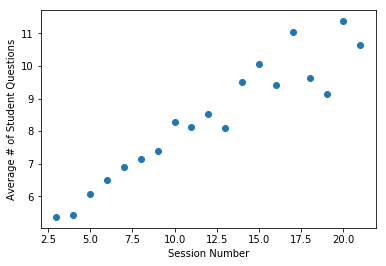

In [65]:
ses_full['ses_num_order'] = ses_full['ses_num_order'] + 1

average_num_student_questions_by_session_number = ses_full.groupby('ses_num_order')['question_student_count'].mean()
plt.scatter(average_num_student_questions_by_session_number.index[:19]\
            ,average_num_student_questions_by_session_number.values[:19])\
           #, c = gb_rate_by_session_number.values[:30])
plt.xlabel('Session Number')
plt.ylabel('Average # of Student Questions')
#plt.savefig('images/blogplot1.png')
#plt.colorbar()

## Turn your child into Socrates with Yup

Yup's tutoring system is built towards encouraging the development of a growth mindset in their students. Tutors are focused on crafting a participative learning environment rather than giving out answers. 

Using mobile chat as a platform gives students a familar structure of communication that doesn't  exist in traditional education environments. Students know they are expected to respond leading to an interactive learning experience. 

One year into to Yup's new socratic learning framework we've seen the student-tutor flourish as the student uses the service. 

INSERT VISUALIZATION

As you can see there is a clear trend of student's asking their tutor more questions every time they use the app. On average, students ask 3 more question on their 10th session as they do on their 1st. And this translates to a big jump in learning outcomes:

INSERT Learning visualization

As students use yup more we see a a large jump in successful sessions too. On average, students are successful 37% more on their 10th session as they are on their 10th.


Questions for Michael:

What can be added to the effect of:
Yup does BLANK to deepen the student tutor iteraction
I see students recognize tutors and vice versa, is the a result of a small user base or by design?


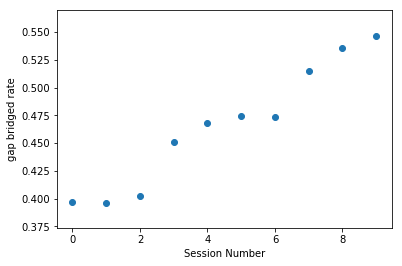

In [57]:
gb_rate_by_session_number = ses_full.groupby('ses_num_order')['gb_bool'].mean()

plt.scatter(gb_rate_by_session_number.index[:10],gb_rate_by_session_number.values[:10])
plt.xlabel('Session Number')
plt.ylabel('gap bridged rate')

* Over the first 20 sessions the number of questions asked by students doubles
* Over the same period learning sucees increases by 20 percentage points.
* We see parabolas in steps
    * Could this be a students giving up and leaving the smarter/suceesful students to continue

# Messages

In [180]:
#message processing, look closly at the following variables:
#[['wait_time', 'length_of_session', 'student_complained','avg_tutor_response_time','max_tutor_response_time']]

#Should be able to define these easily from message data without so many nans
msg.dtypes


session_id          object
created_at          object
sent_from           object
sent_to             object
content_type        object
text                object
created_at_clean    object
text_readable       object
dtype: object

In [96]:

# Student messages
# Tutor messages
# Word_count
# Question mark count
# Emoji Count
ses_1_42.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39369 entries, 0 to 39368
Data columns (total 80 columns):
session_id                          39369 non-null int64
tutor_id                            36157 non-null float64
student_id                          39369 non-null int64
timestamp                           39369 non-null object
feedback_score                      33836 non-null float64
wait_time                           39369 non-null float64
ended_by_reason                     39344 non-null object
session_category                    39366 non-null object
consolidated_session_category       33863 non-null object
student_complained                  39369 non-null bool
student_complaint_clarity           39369 non-null bool
student_complaint_speed             39369 non-null bool
student_complaint_subject           39369 non-null bool
student_complaint_other             39369 non-null bool
session_tag_cheating                39369 non-null bool
session_tag_inappropriate       

In [141]:
#aggrgates
ses_1_42['ques_per_msg'] = 1.0*ses_1_42.question_count / ses_1_42.total_count_msg
ses_1_42['words_per_msg'] = 1.0*ses_1_42.word_count / ses_1_42.total_count_msg
for word in ques_start:
    ses_1_42[word + str('_per_msg')] = 1.0*ses_1_42[word] / ses_1_42.total_count_msg

In [90]:
ses

In [106]:
miss_gb = ses_1_42[(pd.isnull(ses_1_42.word_count))& (ses_1_42.consolidated_session_category == 'gap-bridged')]['session_id']

In [160]:
ses_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34026 entries, 0 to 39368
Data columns (total 73 columns):
session_id                          34026 non-null int64
tutor_id                            32410 non-null float64
student_id                          34026 non-null int64
timestamp                           34026 non-null object
feedback_score                      30979 non-null float64
wait_time                           34026 non-null float64
ended_by_reason                     34001 non-null object
session_category                    34023 non-null object
consolidated_session_category       31006 non-null object
student_complained                  34026 non-null bool
student_complaint_clarity           34026 non-null bool
student_complaint_speed             34026 non-null bool
student_complaint_subject           34026 non-null bool
student_complaint_other             34026 non-null bool
session_tag_cheating                34026 non-null bool
session_tag_inappropriate       

In [98]:
msg.groupby('first_word')['session_id'].count().sort_values(ascending = False)[:20] #top 10 words

first_word
i         110429
yes       87704 
so        78212 
ok        64903 
what      56528 
no        51929 
can       47802 
we        41580 
do        38137 
that's    34243 
you       33706 
the       33651 
is        33378 
okay      32916 
how       32185 
so,       32115 
not       31524 
oh        30318 
great!    27422 
and       26466 
Name: session_id, dtype: int64